### TODO:





### IDEAS
How is this affecting di
* This could be an ongoing project with a website track how events affect different disorders and suicidal posts
* Build models detecting each subreddit. Then use prob for seeing how anxious, paranoid, etc, each post is. And I think most will become more similar to anxiety as corona virus increases
* predict flu trends (CDC) with healthanxiety posts
* Predict if post is from a certain disorder, is suicidal, pre or post coronavirus,  
* model this with important events: https://towardsdatascience.com/inferring-causality-in-time-series-data-
* How is coronavirus affecting divorce/finance?
* How is health anxiety - social anxiety - mindfulness
* 

In [1]:
# # Run this cell to be able to mount GDrive and attach it to the colab so that we can save json outputs
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
'''
Authors: Daniel M. Low
License: Apache 2.0

'''


import os
import sys
import numpy as np
import pandas as pd
import json
from pprint import pprint
import requests
import time

from datetime import datetime, date, timedelta
import string
from scipy import stats
from scipy.stats import zscore

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
import plotly.express as px
from plotly import graph_objs as go

# sys.path.append('./../../catpro')
# from catpro.preprocessing_text.extract_features import liwc, words, punctuation_count, sentiment_analysis, count_words, tfidf

import plotly.express as px
import plotly.graph_objs as go
import chart_studio.plotly as py

In [3]:
from collections import Counter
def histogram(y):
    sns.set(style='white', rc={'figure.figsize':(10,8)}, palette = "coolwarm", font_scale =1)
    labels, values = zip(*Counter(y).items())
    labels, values  = zip(*sorted(zip(labels, values )))
    labels = [int(n) for n in labels]


    indexes = np.arange(len(labels))
    width = 1

    plt.bar(indexes, values, width)
    plt.xticks(indexes + width * 0.5, labels)
    plt.show()
    return


In [4]:
# input y variable across time


def plot_across_time(subreddits, x = None, y_col = '', y_col_div_by = '', zscore=False, ylabel='Average negative sentiments',filter_small = True, small_value = 150, plot_raw = True, 
                     plot_line = True, alpha = 0.3, plot_covid_curves = False):
    '''
    y_col: {'all_words', ''}
    y_col_div_by: {'total_posts'}
    small_vale = if you want to include small posts, set to 0. 150 shizophrenia
    '''
    sns.set(style='white', rc={'figure.figsize':(10,8)}, font_scale =1.5)
    cmap = cm.Set3 # tab20c Set3
    cmap = cm.jet(np.linspace(0,1,len(subreddits)+1))
        
    # Load each rubreddit 
    for i,subreddit in enumerate(subreddits):

        df_subreddit = pd.read_csv(output_dir+'features_{}_0.csv'.format(subreddit))
        # Some just have avg 10 posts per time segment, so not worth plotting        
        total_posts = df_subreddit[['subreddit', 'date']].groupby(['date']).agg(['count']).values
        if np.mean(total_posts)  < small_value:
            continue
        # Load y
        if y_col == 'total_posts':
            y = total_posts.copy()
        else:
            y = df_subreddit[[y_col, 'date']].groupby(['date']).agg(['sum']).values
        if y_col_div_by == 'total_posts':
            y = y/total_posts
        
        y = [n[0] for n in y]
        if zscore:
            if len(np.unique(y)) == 1:
                # By mistake I downloaded every 3 days and some subreddits max at 1000, so zscore of same values (1000,1000,..., 1000) is not possible                 
                continue
            else:
                y = stats.zscore(y)

        # Load x, is the same for all         
        if x == None:
            x = list(set(df_subreddit['date'].values))
            try: x.remove(np.nan)
            except: pass
            x.sort()
        x_num =range(len(x))  
        if plot_raw:
            plt.plot(x,y, alpha=alpha,color=cmap[i])
        if plot_line:
            m, b = np.polyfit(x_num, y, 1)
            plt.plot(x, m*x_num + b, color=cmap[i], alpha=1,label='r/'+subreddit)
        else:
            plt.plot(x,y, alpha=1,color=cmap[i],label='r/'+subreddit)
    
    plt.xticks(ticks=range(len(list(x))), labels=list(x),rotation=90)
    
    # Plot covid confirmed cases 
    if plot_covid_curves:
        for y_country, country,color in zip(y_countries, countries, ['k','gray','darkgray']):
            plt.plot(x,y_country, alpha=1,color=color, label='Confirmed cases - {}'.format(country))
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    if zscore:
        ylabel += ' (z-score)'
    plt.ylabel(ylabel)
    return



    

In [5]:

def boxplot_across_time(subreddit, x = None, y_col = '', y_col_div_by = '', zscore=False, ylabel='Average negative sentiments',filter_small = True, small_value = 150, plot_raw = True, 
                     plot_line = True, alpha = 0.3, plot_covid_curves = False):
    '''
    y_col: {'all_words', ''}
    y_col_div_by: {'total_posts'}
    small_vale = if you want to include small posts, set to 0. 150 shizophrenia
    '''
    sns.set(style='white', rc={'figure.figsize':(10,8)}, font_scale =1.5)
    cmap = cm.Set3 # tab20c Set3
    cmap = cm.jet(np.linspace(0,1,len(subreddits)+1))
        
    # Load each rubreddit 
    for i,subreddit in enumerate(subreddits):

        df_subreddit = pd.read_csv(output_dir+'features_{}_0.csv'.format(subreddit))
        # Some just have avg 10 posts per time segment, so not worth plotting        
        total_posts = df_subreddit[['subreddit', 'date']].groupby(['date']).agg(['count']).values
        if np.mean(total_posts)  < small_value:
            continue
        # Load y
        y = df_subreddit[[y_col, 'date']].groupby(['date']).agg(['sum']).values
        if y_col_div_by == 'total_posts':
            y = y/total_posts
        
        y = [n[0] for n in y]
        if zscore:
            if len(np.unique(y)) == 1:
                # By mistake I downloaded every 3 days and some subreddits max at 1000, so zscore of same values (1000,1000,..., 1000) is not possible                 
                continue
            else:
                y = stats.zscore(y)

        # Load x, is the same for all         
        if x == None:
            x = list(set(df_subreddit['date'].values))
        x_num =range(len(x))  
        if plot_raw:
            plt.plot(x,y, alpha=alpha,color=cmap[i])
        if plot_line:
            m, b = np.polyfit(x_num, y, 1)
            plt.plot(x, m*x_num + b, color=cmap[i], alpha=1,label='r/'+subreddit)
        else:
            plt.plot(x,y, alpha=1,color=cmap[i],label='r/'+subreddit)
    
    plt.xticks(ticks=range(len(list(x))), labels=list(x),rotation=90)
    
    # Plot covid confirmed cases 
    if plot_covid_curves:
        for y_country, country,color in zip(y_countries, countries, ['k','gray','darkgray']):
            plt.plot(x,y_country, alpha=1,color=color, label='Confirmed cases - {}'.format(country))
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    if zscore:
        ylabel += ' (z-score)'
    plt.ylabel(ylabel)
    return



    

In [6]:
# Load data
# output_dir = './../../datum/reddit/input/'

# potential output dir if drive has been mounted:
# output_dir = '/content/drive/My Drive/reddit_json/'
input_dir = './../../datum/reddit/input/'
subreddits = os.listdir(input_dir+'feature_extraction')
subreddits = [n.replace('_post_features.csv','') for n in subreddits if 'post' in n]
subreddits

['addiction',
 'guns',
 'socialanxiety',
 'schizophrenia',
 'healthanxiety',
 'suicidewatch',
 'EDAnonymous',
 'mentalhealth',
 'COVID19_support',
 'teaching',
 'fitness',
 'personalfinance',
 'meditation',
 'bipolarreddit',
 'adhd',
 'conspiracy',
 'autism',
 'mentalillness',
 'alcoholism',
 'bpd',
 'ptsd',
 'divorce',
 'legaladvice',
 'jokes',
 'mindfulness',
 'anxiety',
 'depression',
 'parenting',
 'relationships',
 'lonely']

In [7]:
# df_corr = df.corr(method='pearson').T.n_words
# df_corr.tail(20)

In [8]:
# df_corr[df_corr<0.12].index
# df_corr[df_corr>0.12].index

In [9]:
# # example of outlier: personalfinance_post 
# '2020/04/05'

# y = df[df.date == '2020/04/05'].anxiety
# # list(y).index(13) #294

# try:
#     sample = df[df.date == '2020/04/05'].iloc[294]

# except: 
#     sample = df[df.date == '2020/04/05'].iloc[0]
#     pass

# anxiety_score = sample.anxiety
# print('anxiety: ', anxiety_score)
# post = sample.post

# print('amount of characters (long): ', len(post))

# print(post[:200])

# # histogram(y)

In [10]:
def timeseries_summary(input_dir, subreddit = 'personalfinance', pre_or_post = 'post', 
                       timestep = 3, metric='mean',weigh_by_Nwords = True,filter_days = False, zscore_slope = True):
    # Merge different types of features     
    df = pd.read_csv(input_dir+'feature_extraction/{}_{}_features.csv'.format(subreddit,pre_or_post))
#     df_phrases = pd.read_csv(input_dir+'phrases_features/{}_{}_phrases.csv'.format(subreddit,pre_or_post))

    # assert df_features.shape[0] == df_phrases.shape[0]
    # assert list(df_features.author) == list(df_phrases.author)
#     df = df_features.merge(df_phrases,how='inner' ) #inner is default, will elimante rows not shared on shared cols (post, author, etc, date)
    # https://stackoverflow.com/questions/53645882/pandas-merging-101
    features = list(df.columns)
    features = [n for n in features if n not in ['subreddit','author','date','post']]
    
    # Weigh value by amount of words in posts (if not amount of words will confound patterns in other variables)     
    if weigh_by_Nwords:
        # weight these variables by n_words
        weigh = features.copy()
        [weigh.remove(n) for n in ['n_chars', 'n_sents', 'n_words','sent_neg', 'sent_neu', 'sent_pos','sent_compound', 'automated_readability_index', 'coleman_liau_index',
               'flesch_kincaid_grade_level', 'flesch_reading_ease', 'gulpease_index',
               'lix', 'wiener_sachtextformel', 'gunning_fog_index', 'smog_index']]
        df[weigh] = df[weigh].div(df['n_words'].values, axis=0)

    
    # Group value by timestep     
    days = np.unique(df.date)
    if filter_days:
        for day in filter_days:
            days = [n for n in days if day not in n]
    days_timestep = days[::timestep]
    X = []
    y = []
    for i in range(0,len(days),timestep):
      days_week = days[i:i+timestep]
      df_week = df[df.date.isin(days_week)]
      df_week_feature_cols = df_week[features].values
      df_week_y = list(df_week.subreddit)
      X.append(df_week_feature_cols)
      y.append(df_week_y)

    X = np.array(X)
    y = np.array(y)
    
    # Take summary stat metric by timestep     
    summary = []
    for timestep in X:
        n_posts = timestep.shape[0] 
        if metric == 'mean':
            summary_timestep = timestep.mean(axis=0)
            summary_timestep = np.append(summary_timestep, n_posts)
        summary.append(summary_timestep)

    summary = pd.DataFrame(summary)
    summary = summary.apply(zscore)
    summary = summary.T
    summary.columns = days_timestep
    summary.index = features+['n_posts']



    # add slope and p-value
    slopes = []
    p_values = []
    significances = []
    r2 = []
    for feature in features+['n_posts']:
        slope, intercept, r_value, p_value, std_err = stats.linregress(range(len(summary.T.index)), summary.T[feature])
        slopes.append(slope)
        p_values.append(p_value)
        r2.append(r_value**2)
        corrected_alpha = 0.05     # corrected_alpha = 0.05/len(features)
        if p_value <= corrected_alpha:
            significances.append(1)
        else:
            significances.append(-1)
    
    if zscore_slope:
        summary['slope'] = stats.zscore(slopes)
        summary['p_value'] = stats.zscore(p_values)
        summary['sign'] = stats.zscore(significances)
        summary['r2'] = stats.zscore(r2)
    else:
        summary['slope'] = slopes
        summary['p_value'] = p_values
        summary['sign'] = significances
        summary['r2'] = r2
        
    return summary
    

In [11]:
# Filter features
keep = [
    'n_posts', 'n_words', 'flesch_kincaid_grade_level', 'lix',
       'n_monosyllable_words', 'n_unique_words', 'punctuation',   
#     functionals    
    'liwc_total_functional', 'liwc_impersonal_pronouns', 'liwc_total_pronouns', 'liwc_personal_pronouns',
'liwc_1st_pers', 'liwc_2nd_pers', 'liwc_3rd_pers', 
       'liwc_articles_article', 'liwc_common_verbs',
#     POS
       'liwc_auxiliary_verbs', 'liwc_past_tense', 'liwc_present_tense', 'liwc_future_tense',
       'liwc_adverbs', 'liwc_prepositions', 'liwc_conjunctions', 'liwc_negations',    'liwc_assent',
       'liwc_quantifiers', 'liwc_numbers', 
    'liwc_nonfluencies', 'liwc_fillers',
#    Sentiment 
    'sent_neg', 'sent_neu', 'sent_pos',
       'sent_compound', 
    'liwc_affective_processes',
       'liwc_positive_emotion', 'liwc_negative_emotion', 'liwc_anxiety', 'liwc_anger','liwc_swear_words', 
       'liwc_sadness',
# Existential / death    
    'liwc_religion', 
    'liwc_death', 'guns_total','substance_use_total', 'suicidality_total',
# Cognitive    
    'liwc_cognitive', 'liwc_insight', 'liwc_causation', 'liwc_discrepancy',
       'liwc_tentative', 'liwc_certainty', 'liwc_inhibition', 'liwc_inclusive', 'liwc_exclusive',
       'liwc_perceptual_processes', 'liwc_see', 'liwc_hear', 'liwc_feel', 
# Biological
    'liwc_biological',
'liwc_ingestion', 'liwc_relativity', 'liwc_motion','liwc_body', 'liwc_health', 'liwc_sexual', 
    # Work, economic stress, leisure
    'liwc_work',     'liwc_leisure',  'economic_stress_total', 'liwc_money','liwc_time','liwc_achievement',
    # Social and home and isolation
    'liwc_social_processes','liwc_home',         
    'domestic_stress_total','liwc_space',    
       'liwc_family', 'liwc_friends', 'liwc_humans', 'isolation_total',
#     covid
        'covid19_total',  
    
]





In [12]:
df = pd.read_csv(input_dir+'feature_extraction/{}_{}_features.csv'.format('healthanxiety','post'))
df.columns

Index(['subreddit', 'author', 'date', 'post', 'automated_readability_index',
       'coleman_liau_index', 'flesch_kincaid_grade_level',
       'flesch_reading_ease', 'gulpease_index', 'gunning_fog_index', 'lix',
       'smog_index', 'wiener_sachtextformel', 'n_chars', 'n_long_words',
       'n_monosyllable_words', 'n_polysyllable_words', 'n_sents',
       'n_syllables', 'n_unique_words', 'n_words', 'sent_neg', 'sent_neu',
       'sent_pos', 'sent_compound', 'covid19_total', 'economic_stress_total',
       'isolation_total', 'substance_use_total', 'guns_total',
       'domestic_stress_total', 'suicidality_total', 'punctuation',
       'liwc_1st_pers', 'liwc_2nd_pers', 'liwc_3rd_pers', 'liwc_achievement',
       'liwc_adverbs', 'liwc_affective_processes', 'liwc_anger',
       'liwc_anxiety', 'liwc_articles_article', 'liwc_assent',
       'liwc_auxiliary_verbs', 'liwc_biological', 'liwc_body',
       'liwc_causation', 'liwc_certainty', 'liwc_cognitive',
       'liwc_common_verbs', 'liwc_c

In [13]:
subreddit = 'depression'
summary = timeseries_summary(input_dir, subreddit = subreddit, pre_or_post = 'post', 
                       timestep = 2, metric='mean',weigh_by_Nwords = True, filter_days = False,zscore_slope=False)





In [14]:


summary2 = summary.T[keep].T


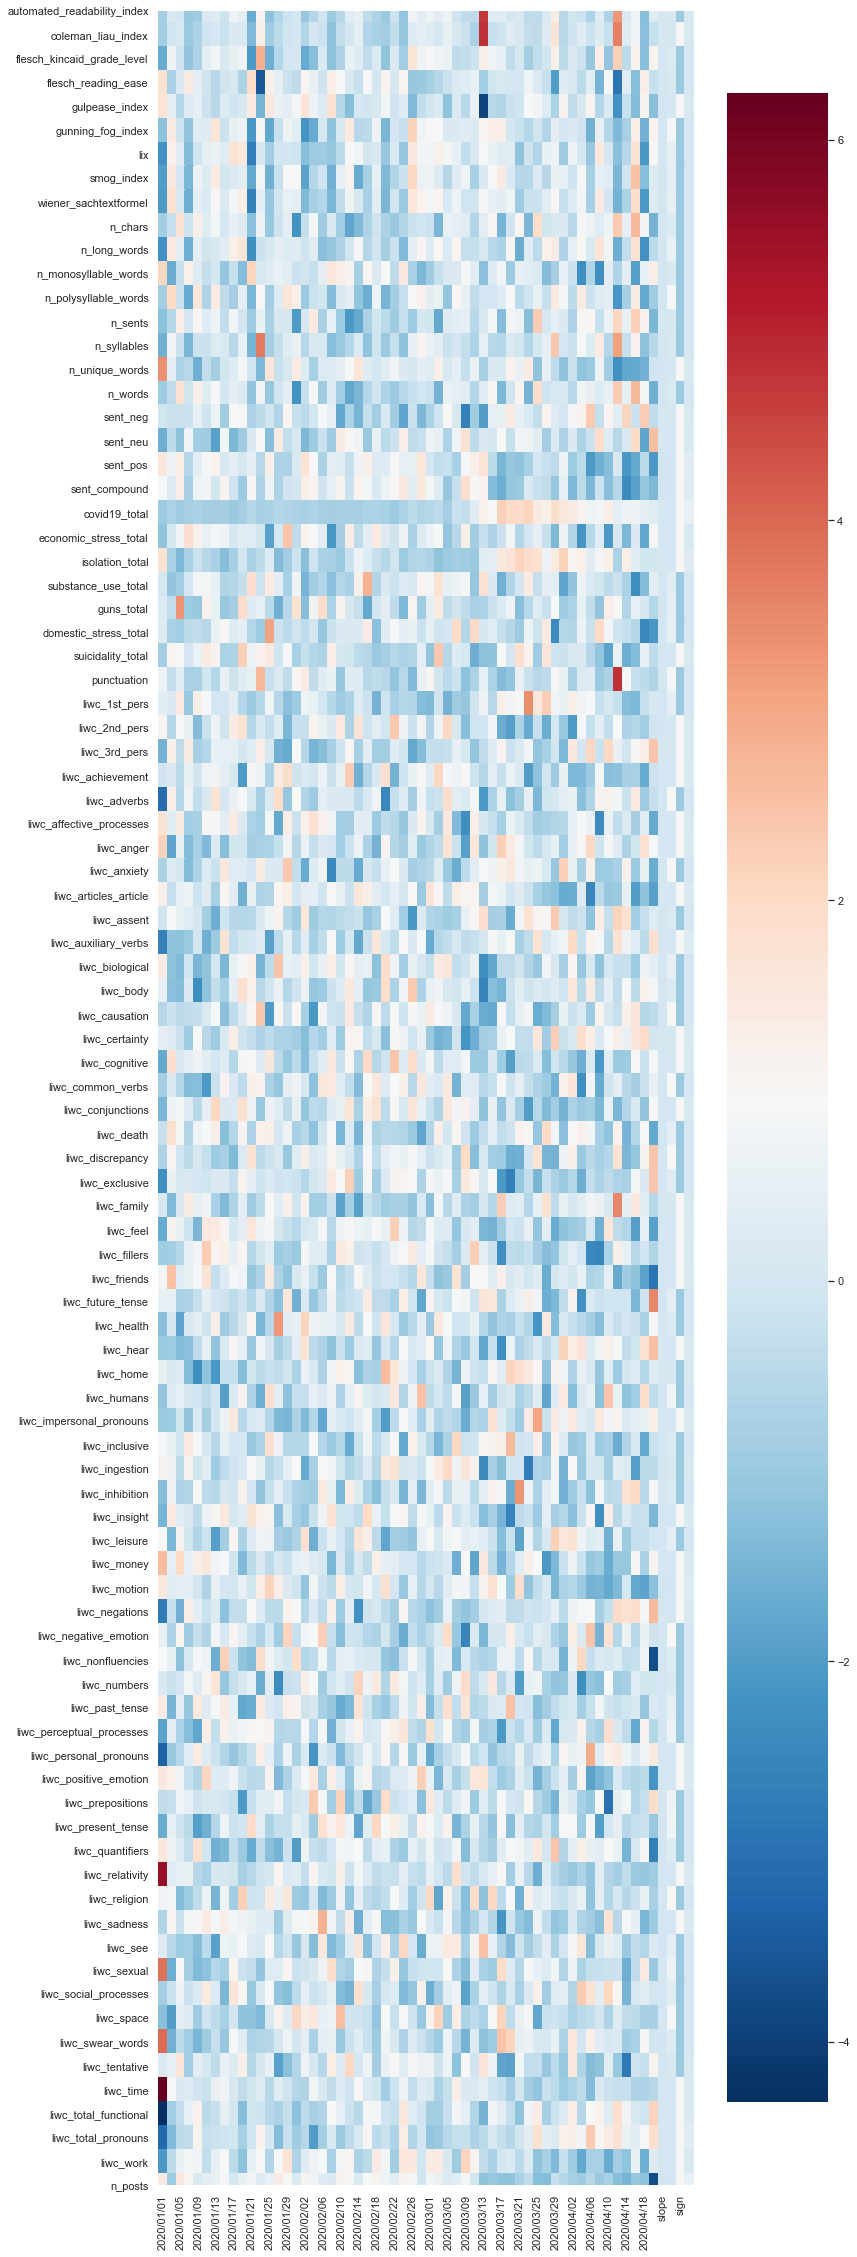

In [15]:
# Plot
sns.set(style='white', rc={'figure.figsize':(12,40)}, font_scale =1)
sns.heatmap(summary, cmap = 'RdBu_r')

In [16]:
summary.r2.sort_values()[-15:]

liwc_personal_pronouns      0.168780
liwc_relativity             0.176783
liwc_friends                0.178726
liwc_sadness                0.179883
liwc_time                   0.181442
liwc_articles_article       0.194248
liwc_impersonal_pronouns    0.195941
liwc_auxiliary_verbs        0.244157
liwc_motion                 0.249567
sent_compound               0.263076
isolation_total             0.270526
liwc_total_pronouns         0.320893
sent_pos                    0.325083
n_posts                     0.523718
covid19_total               0.580195
Name: r2, dtype: float64

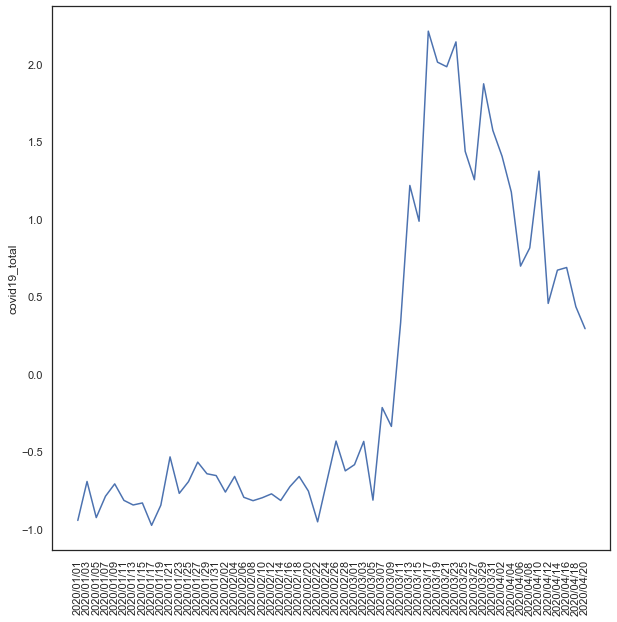

In [17]:
sns.set(style='white', rc={'figure.figsize':(10,10)}, font_scale =1)
variable = 'covid19_total' 
# for variable in 
plt.plot(summary.columns[:-4], summary.T[variable][:-4])
plt.title('')
plt.ylabel(variable)
plt.xticks(rotation=90)
plt.show()


=====n_posts====


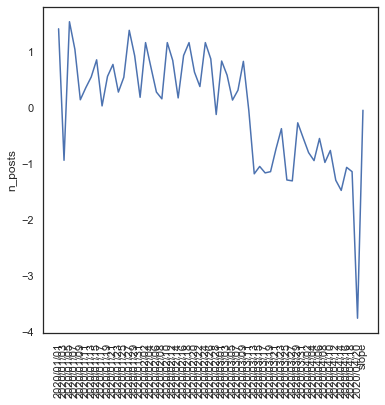


=====covid19_total====


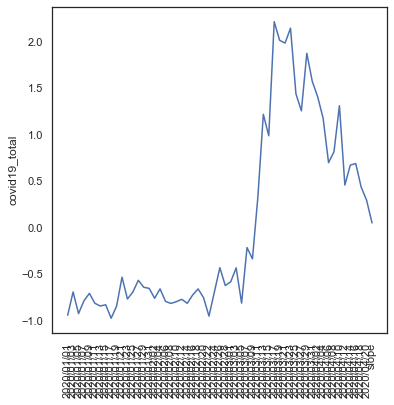

In [18]:

# for variable in keep:
for variable in ['n_posts', 'covid19_total']:
    print('\n====={}===='.format(variable))
    sns.set(style='white', rc={'figure.figsize':(6,6)}, font_scale =1)
    plt.plot(summary.columns[:-3], summary.T[variable][:-3])
    plt.title('')
    plt.ylabel(variable)
    plt.xticks(rotation=90)
    plt.show()

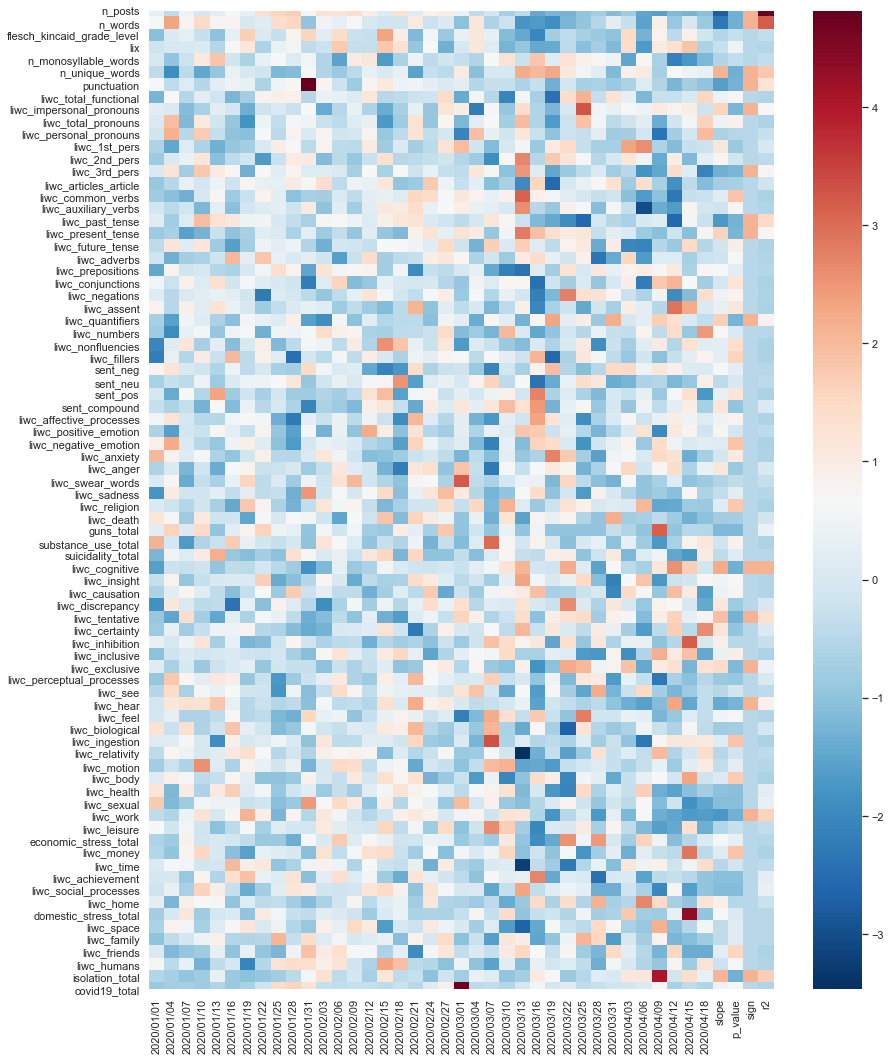

In [19]:
# See early spike and increase in negativity
subreddit = 'healthanxiety'
summary = timeseries_summary(input_dir, subreddit = subreddit, pre_or_post = 'post', 
                       timestep = 3, metric='mean',weigh_by_Nwords = True)

# Reorder features and filter
summary = summary.T[keep].T

# Plot
sns.set(style='white', rc={'figure.figsize':(14,18)}, font_scale =1)
sns.heatmap(summary, cmap = 'RdBu_r')


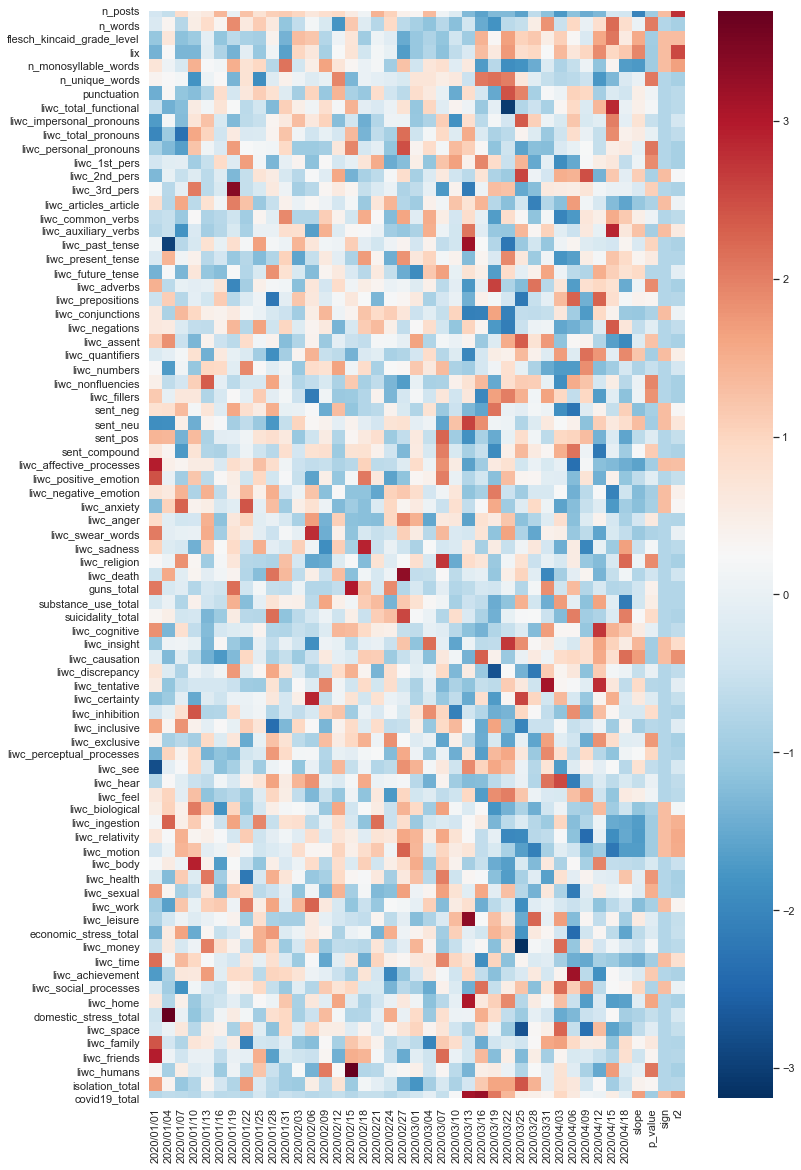

In [20]:
# Decrease in negativity
subreddit = 'socialanxiety'
summary = timeseries_summary(input_dir, subreddit = subreddit, pre_or_post = 'post', 
                       timestep = 3, metric='mean',weigh_by_Nwords = True)

# Reorder features and filter
summary = summary.T[keep].T

# Plot
sns.set(style='white', rc={'figure.figsize':(12,20)}, font_scale =1)
sns.heatmap(summary, cmap = 'RdBu_r')


## Summary of trends across disorders

In [21]:
# Plot all subreddits. Todo add more.
subreddits = os.listdir(input_dir+'feature_extraction')
subreddits = [n.replace('_post_features.csv','') for n in subreddits if 'post'in n]
# subreddits.remove('COVID19')
# subreddits.remove('fitness')
# subreddits.remove('legaladvice')
# subreddits.remove('relationships')

# subreddits.append('COVID19_support')
# subreddits.sort()

# order by similarity
# subreddits2 = [
#               'addiction', 'alcoholism', 'EDAnonymous', 
#               'schizophrenia', 
#               'bipolarreddit', 'bpd', 
#               'suicidewatch', 'depression', 'ptsd',  
#               'anxiety','healthanxiety', 'socialanxiety', 'jokes', 
#               'personalfinance',]

slope_all = []
r2_all = []
p_value_all = []

for sr in subreddits:
    print(sr)
    summary_sr = timeseries_summary(input_dir, subreddit = sr, pre_or_post = 'post', 
                       timestep = 2, metric='mean',weigh_by_Nwords = True, zscore_slope =False)
    summary_sr_slope = summary_sr[['slope']] #add 'p-value'
    slope_all.append(summary_sr_slope)
    # r2 
    r2_all.append(summary_sr[['r2']]) #add 'p-value'
    # p value     
    p_value_all.append(summary_sr[['p_value']])
    

    



addiction
guns
socialanxiety
schizophrenia
healthanxiety
suicidewatch
EDAnonymous
mentalhealth
COVID19_support
teaching
fitness
personalfinance
meditation
bipolarreddit
adhd
conspiracy
autism
mentalillness
alcoholism
bpd
ptsd
divorce
legaladvice
jokes
mindfulness
anxiety
depression
parenting
relationships
lonely


In [22]:
len(subreddits)
df_slope = pd.concat(slope_all, axis=1)
df_slope.shape
cols = [[sr] for sr in subreddits] #cols = [[sr,'p-zscore'] for sr in subreddits]
cols= [n for i in cols for n in i]
df_slope.shape
df_slope.columns = cols
df_slope = df_slope.T[keep].T




In [23]:
len(subreddits)
df_r2 = pd.concat(r2_all, axis=1)
df_r2.shape
cols = [[sr] for sr in subreddits] #cols = [[sr,'p-zscore'] for sr in subreddits]
cols= [n for i in cols for n in i]
df_r2.shape
df_r2.columns = cols
df_r2 = df_r2.T[keep].T

In [24]:
len(subreddits)
df_p_value = pd.concat(p_value_all, axis=1)
df_p_value.shape
cols = [[sr] for sr in subreddits] #cols = [[sr,'p-zscore'] for sr in subreddits]
cols= [n for i in cols for n in i]
df_p_value.shape
df_p_value.columns = cols
df_p_value = df_p_value.T[keep].T

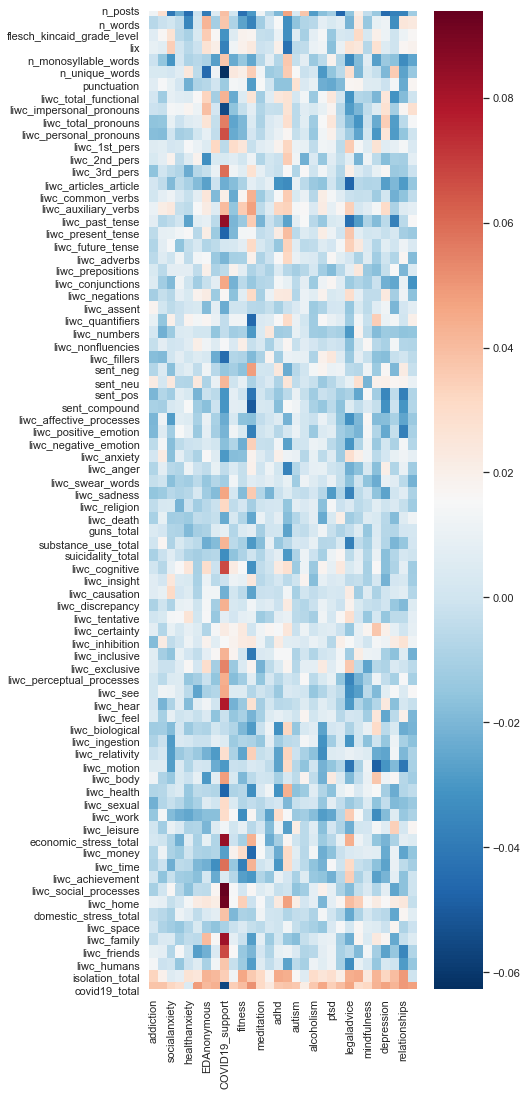

In [25]:
# Reorder features and filter
sns.set(style='white', rc={'figure.figsize':(6,18)}, font_scale =1)
sns.heatmap(df_slope, cmap='RdBu_r')

Mentioning covid19: Healthanxiety was always talking about it, so it's not increases
Numbers: personalfinance is decreasing (less about specific errands and more about psychology/complaints?

Certainty: increase in Anxiety. Could this be that Anxiety is less certain (Does it count "I'm not sure")

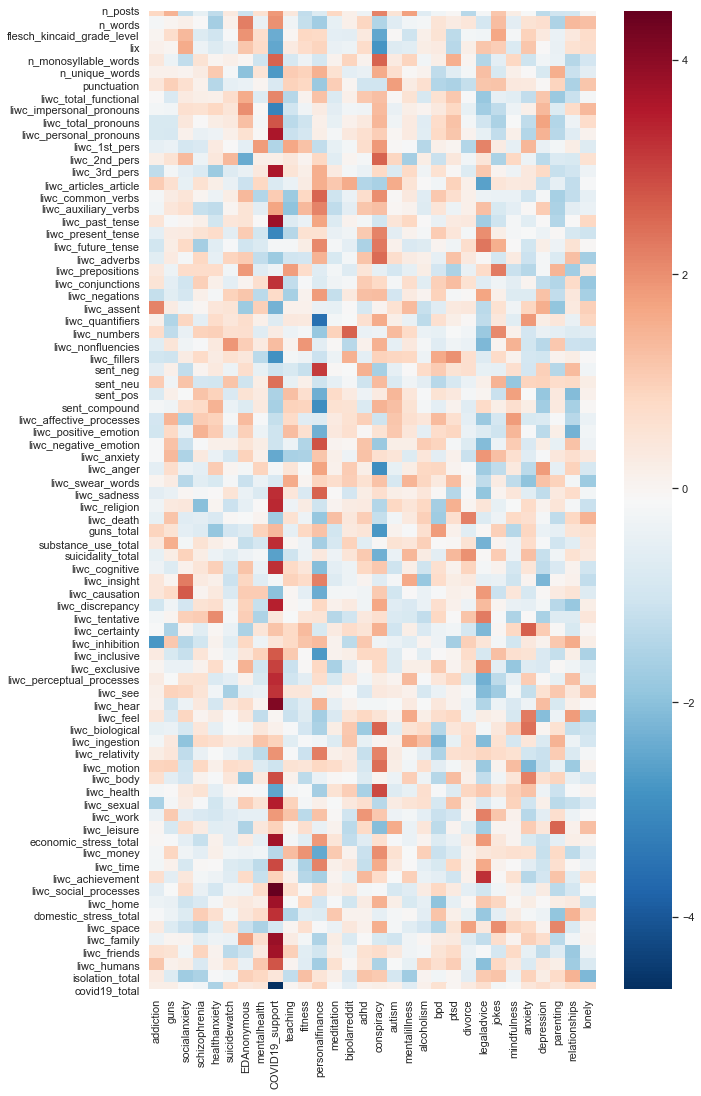

In [26]:
# Zscore on feature cols
df_zscore = df_slope.T.apply(zscore).T
sns.set(style='white', rc={'figure.figsize':(10,18)}, font_scale =1)
sns.heatmap(df_zscore, cmap='RdBu_r')

In [27]:
liwc = pd.read_csv('./../../datum/util_nlp/liwc_english_dictionary/categories.txt', sep=',').iloc[:,1].values

liwc_words = np.load('./../../datum/util_nlp/liwc_english_dictionary/liwc.npy',allow_pickle=True).item()

liwc_words['sadness'][:15]

['abandon',
 'ache',
 'aching',
 'agoniz',
 'agony',
 'alone',
 'broke',
 'cried',
 'cries',
 'crushed',
 'cry',
 'crying',
 'damag',
 'defeat',
 'depress']

<Figure size 1440x1440 with 0 Axes>

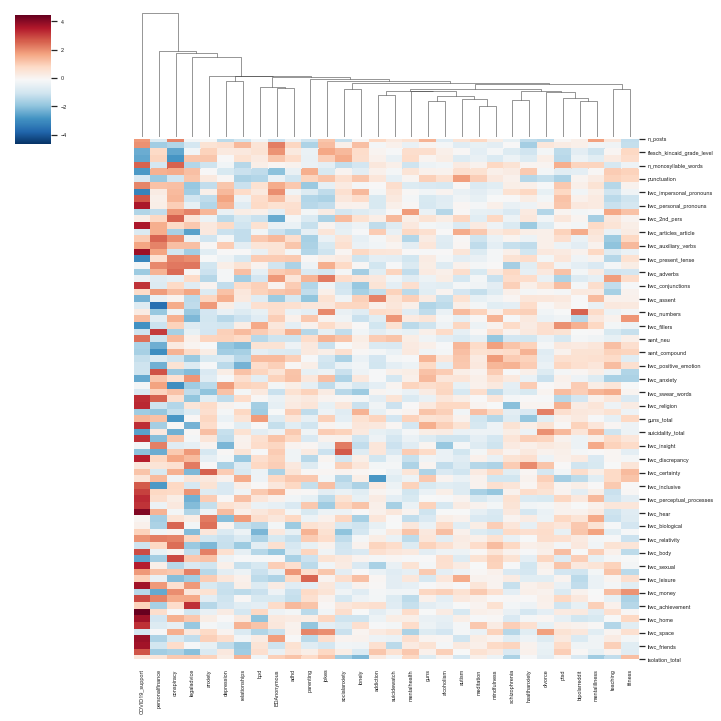

In [28]:
# Clustermap
sns.set(style='white', rc={'figure.figsize':(100,100)}, font_scale =0.5)
# df_zscore_corr = df_zscore.corr()
plt.figure(figsize = (20,20))
sns.clustermap(df_zscore, cmap='RdBu_r', linewidths=0, row_cluster=False)
plt.savefig('./../../datum/reddit/output/clustermap.png', dpi=200)

# Filter more features. Redo with all final subreddits (see try except below)

In [29]:
subreddits2 = ['addiction',
 'alcoholism',
 'EDAnonymous',
 'schizophrenia',
 'bipolarreddit',
 'bpd',
 'suicidewatch',
 'depression',
 'ptsd',
 'anxiety',
 'healthanxiety',
 'socialanxiety',
 'jokes',
 'personalfinance']
subreddits3 = ['addiction',
 'alcoholism',
 'EDAnonymous',
 'bpd',
 'suicidewatch',
 'depression',
 'ptsd',
 'anxiety',
 'healthanxiety',
 'socialanxiety',
 'personalfinance']


In [30]:


# highest_features = []
# df_all = []
# for subreddit in subreddits2:
#     try: summary = timeseries_summary(input_dir, subreddit = subreddit, pre_or_post = 'post', 
#                        timestep = 1, metric='mean',weigh_by_Nwords = True, filter_days = False,zscore_slope=False)
#     except:
#         print(subreddit, ' does not exist')
#         continue
#     # Reorder features and filter
#     #     summary = summary.T[keep].T    
#     highest_features_sr_df = summary[summary.r2>=0.20]
#     highest_features_sr_index = list(highest_features_sr_df.index)
    
#     df_sr = pd.DataFrame()
#     df_sr['subreddit'] = [subreddit for n in highest_features_sr_index]
#     df_sr['features'] = highest_features_sr_index
#     df_sr['r2'] =  highest_features_sr_df.r2.values
#     df_sr['slope'] =  highest_features_sr_df.slope.values
#     df_sr['p_value'] =  highest_features_sr_df.p_value.values
#     df_all.append(df_sr)

#     highest_features.append(highest_features_sr_index)
#     #     highest_features_values_sr = list(summary[summary.r2.sort_values()>0.35].values)
#     #     highest_features_values_sr.append(highest_features_values_sr)

# df_all = pd.concat(df_all)


In [31]:
# df_all.head()

In [32]:
# highest_features2 = [n for i in highest_features for n in i]
# highest_features2 = np.unique(highest_features2)
# highest_features2

# remove similar features OR group




In [33]:
# to_remove = ['wiener_sachtextformel','flesch_kincaid_grade_level', 'flesch_reading_ease','lix',
#              'covid19_total', 
#              'n_chars', 'n_sents',
#             'sadness', 'positive_emotion', 'negative_emotion',

# 'auxiliary_verbs', 'body', 'certainty', 'economic_stress_total',
#        'family', 'home', 'impersonal_pronouns', 'inclusive', 'isolation_total',
#        'money', 'motion', 'n_posts', 'n_unique_words', 'n_words',
#        'negative_emotion', 'positive_emotion', 'quantifiers', 'relativity',
#        'sadness', 'sent_compound', 'sent_neg', 'sent_pos', 'time',
#        'total_pronouns',]

# highest_features_filtered = [n for n in highest_features2 if n not in to_remove]




# to_add = ['suicidality_total', 'economic_stress_total', 'isolation_total', 'n_posts','n_words',
# 'sent_neg', 'sent_pos', ]
# [highest_features_filtered.append(n) for n in to_add]
# highest_features_filtered = list(np.unique(highest_features_filtered))

# just run on the original ones

In [34]:

features = ['economic_stress_total', 'isolation_total', 
'sent_neg', 'sent_pos','n_posts']

subreddits3 = ['addiction',
 'EDAnonymous',
 'suicidewatch',
 'depression',
'schizophrenia',
'bipolarreddit',
 'ptsd',
 'anxiety',
 'healthanxiety',
 'socialanxiety',
 'personalfinance', 'relationships']


In [35]:
# Filter subreddits
df_slope_filtered = df_slope[subreddits3]
df_p_value_filtered = df_p_value[subreddits3]
df_r2_filtered =df_r2[subreddits3]

In [36]:
df_r2_signed = df_r2_filtered * ( df_slope_filtered/np.abs(df_slope_filtered))


In [37]:


df_filtered = df_r2_signed.T[features].T


In [38]:
multiple_comparisons = df_filtered.shape[0]*df_filtered.shape[1]
multiple_comparisons
print(multiple_comparisons)
corrected_alpha = 0.05/multiple_comparisons
corrected_alpha

60


0.0008333333333333334

In [39]:
# Mask of corrected p_values
mask = df_p_value_filtered>corrected_alpha #these will be True, and will be masked, not shown
df_p_value_mask_filtered = mask.T[features].T


In [40]:
df_p_value_mask_filtered.index

Index(['economic_stress_total', 'isolation_total', 'sent_neg', 'sent_pos',
       'n_posts'],
      dtype='object')

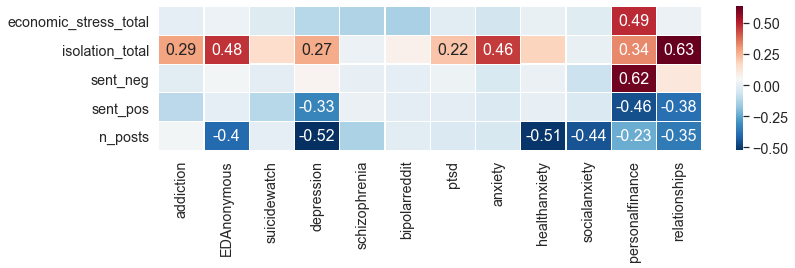

In [42]:

sns.set(style='white', rc={'figure.figsize':(12,4)}, font_scale =1.3)
cmap = plt.get_cmap("RdBu_r")
cmap.set_bad(color='white', alpha=0.05)
plt.clf()
sns.heatmap(df_filtered, cmap ="RdBu_r",cbar = True,linewidths=0.2)
# mask
ax = sns.heatmap(df_filtered, cmap=cmap, cbar = False,mask=df_p_value_mask_filtered, linewidths=0.1,
            annot=True,annot_kws={"fontsize":16})


bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

plt.tight_layout()

plt.savefig('./data/heatmap_r2.png', dpi=300)

In [248]:
output_dir = './../../datum/reddit/input/'

In [249]:
df = pd.read_csv(output_dir+'features_depression_0.csv')
df.shape

(20980, 14)

In [250]:
# Search reddit
# Search unix code https://www.unixtimestamp.com/index.php
# Timeline: https://www.nytimes.com/article/coronavirus-timeline.html


In [251]:
# Anxiety corona virus
# JAN. 20 Other countries, including the United States, confirmed cases.
"I know this may sound silly, but I\u2019m scared of the coronavirus. A lot of people are saying it\u2019s not a big deal and that I\u2019ll be safe as long as I\u2019m healthy. I know all of this but I\u2019m more scared of the fact that this will turn into a pandemic."

# Other days:
# JAN. 30 The W.H.O. declared a global health emergency
# The World Health Organization on Feb. 11 proposed an official name for the disease the virus coronavirus causes: Covid-19
# Feb 23 Italy sees major surge in coronavirus cases and officials lock down towns.
subreddit = 'healthanxiety'
date_start = '2020/03/24'
date_end = '2020/03/30'

start = date2timestamp(date_start)
end = date2timestamp(date_end)
size = 1000000000
url = 'https://api.pushshift.io/reddit/search/submission/?subreddit={}&sort=desc&sort_type=created_utc&after={}&before={}&size={}'.format(subreddit,start, end, size)
print(url)
# filename = 'scrape_reddit'
# filename = filename+'_{}_{}'.format(date_start.replace('/', ''), date_end.replace('/', ''))


# Comment so it won't download

# url2json(url, output_dir+filename)
# anxiety_covid = json2list(output_dir+filename+'.json')

NameError: name 'date2timestamp' is not defined

In [252]:
timestamp2date(1579395379)

NameError: name 'timestamp2date' is not defined

In [253]:
def scrape_reddit(output_dir, subreddit, timeframe, date_start, date_end, size = 1000):
    '''
    size = {1,1000} #amount of posts
    '''
    start = date2timestamp(date_start)
    end = date2timestamp(date_end)
    url = 'https://api.pushshift.io/reddit/search/submission/?subreddit={}&sort=desc&sort_type=created_utc&after={}&before={}&size={}'.format(subreddit,start, end, size)
    filename = '{}_{}_{}_{}'.format(subreddit, timeframe, date_start.replace('/', ''), date_end.replace('/', ''))
    url2json(url, output_dir+filename)
    posts = json2list(output_dir+filename+'.json')
    posts_filtered = []
    for post in posts:
        post_filtered = {}
        for key in post.keys():
            post_filtered[key]=post.get(key)
        posts_filtered.append(post_filtered)
    # np.savez_compressed(input_dir+filename+'.npz',posts_filtered)
#     os.remove(output_dir+filename+'.json')
    return filename
        


In [254]:
date2timestamp(date_start)

NameError: name 'date2timestamp' is not defined

In [255]:
# # # Commented so it won't run on accident





# # start = date2timestamp(date_start)
# # end = date2timestamp(date_end)


# days = list_of_days(date(2020,3,27), date(2020,3,30))
# combinations = [['depression', 'post']]
# size = 1000

# # Scrape: takes a while
# for subreddit, timeframe in combinations:
#     for i in range(len(days))[::3]:
#         try:
#             date_start = days[i]
#             date_end = days[i+3]
#             i=+ 3
#         except:
#             break
#         print(i)
#         print(date_start)
# #         print(subreddit, timeframe, date_start, date_end)
#         filename = scrape_reddit(output_dir, subreddit, timeframe, date_start, date_end, size = size)
# #         posts_filtered = np.load(output_dir+filename+'.npy')

In [256]:
scraped = ['EDAnonymous',
 'addiction',
 'adhd',
 'alcoholism',
 'anxiety',
 'askdocs',
 'askscience',
 'atheism',
 'bipolarreddit',
 'books',
 'bpd',
 'buddhism',
 'christianity',
 'depersonalization',
 'depression',
 'dpdr',
 'eatingdisorders',
 'features',
 'feelgood',
 'fitness',
 'frugal',
 'healthanxiety',
 'jokes',
 'legaladvice',
 'lifeprotips',
 'meditation',
 'mentalhealth',
 'mentalillness',
 'mindfulness',
 'nostupidquestions',
 'paranoia',
 'parenting',
 'personalfinance',
 'psychosis',
 'psychoticreddit',
 'ptsd',
 'randomkindness',
 'relationships',
 'schizophrenia',
 'showerthoughts',
 'socialanxiety',
 'stopselfharm',
 'suicidewatch',
 'talesfromcallcenters',
 'talesfromretail',
 'talesfromtechsupport',
 'teaching',
 'theoryofreddit',
 'writing',
 'writingprompts']




In [257]:

subreddits = ['mentalhealth',
 'socialanxiety',
 'buddhism',
 'depersonalization',
 'randomkindness',
 'ptsd',
 'alcoholism',
 'depression',
 'mindfulness',
 'mentalillness',
 'psychosis',
 'suicidewatch',
 'atheism',
 'bpd',
 'fitness',
 'adhd',
 'stopselfharm',
 'parenting',
 'meditation',
 'healthanxiety',
 'teaching',
 'relationships',
 'schizophrenia',
 'personalfinance',
 'EDAnonymous',
 'jokes',
 'addiction',
 'anxiety',
 'bipolarreddit',
 'paranoia',
 'christianity',
 'legaladvice']


In [258]:
# # Commented so it won't run on accident


# # Load scraped files and Extract features WITHOUT SUMMERIZING

# # features.append([subreddit, timeframe, date_range, total_posts] + [a0,a1,b]+c+c1+c2+d)        
# columns = ['subreddit','timeframe','date','posts','posts_raw', 'all_words', 'covid_total', 'covid_boolean', 'suicide_total','suicide_bool', ]
# sentiment_cols = ['sent_neg','sent_neu', 'sent_pos', 'sent_compound']
# # liwc_cols = pd.read_csv(liwc_dir + 'categories.txt', index_col=0)['0'].tolist()
# columns = columns+sentiment_cols


# covid_words = ['corona','virus','coronavirus', 'pandemic', 'epidemic', 'quarantine', 'covid', 'covid19']
# suicide_words = ['end it', "take it anymore", 'suicide', 'I will overdose','I want to overdose', 'shoot myself', 'hang myself', 'kill myself', "hurt myself", "cut myself",  
#                 'will miss me', 'if I live or die', 'hopeless'] #Look at suicide note corpus for more

# Adam sent these:
# suicide_thoughts = ['suicidal', 'to die', 'death', 'kill', 'kill myself', 'want to die', 'suicide', 'to end', 'wanna die', 'wanna kill', 'commit suicide', 'killing myself', 'killing', 'to kill', 'die', 'dying', 'alive', 'live anymore', 'goodbye', 'this world', 'earth', 'end my', 'my life', 'life anymore', 'live anymore', "i'm done" "i'm just done", 'so done', 'end', 'am done', 'overdose', "I'm done", 'end tonight', 'ends tonight', 'I wish', 'just wish', 'sleep forever', 'never wake', 'commit', 'with life', 'wake up', 'shoot me', 'hang myself', 'a bridge', 'to live', 'wanna live', 'dead', 'be dead', 'just die', 'gun']



# timeframes = ['post']
# combinations = []
# for sr in subreddits:
#     for t in timeframes:
#         combinations.append([sr, t])

# days_all = [list_of_days(date(2019, 1, 19), date(2019, 3, 22)), list_of_days(date(2020, 1, 19), date(2020, 3, 22)),] 


# for subreddit, timeframe in combinations:
#     features_df = pd.DataFrame()
#     print(subreddit)
#     features = []
#     if timeframe == 'pre':
#         days = days_all[0]
#         year = '2019'
#     else:
#         days = days_all[1]
#         year = '2020'
#     # For each timepoint 

#     for i in range(len(days))[::3]:
#         try:
#             date_start = days[i]
#             date_end = days[i+3]
#             i=+ 3
#         except:
#             break
#         filename = '{}_{}_{}_{}'.format(subreddit, timeframe, date_start.replace('/', ''), date_end.replace('/', ''))
#         # Load 1 timepoint         
#         posts = np.load(output_dir+filename+'.npz')['arr_0'] 


#         posts_raw = [(post['title']+' '+post['selftext']).replace('. ', '.\n') for post in posts if post['selftext']!=None and post['title']!=None]
#         posts = [' '.join((post['title']+' '+post['selftext']).split()) for post in posts if post['selftext']!=None and post['title']!=None]
#         date_range = date_start.replace(year+'/', '')+'-'+date_end.replace(year+'/', '')
#         # Features         
#         word_count_all = [words(post) for post in posts_clean] # count all words
#         word_count_covid = [count_words(post, covid_words) for post in posts] # count covid words
#         word_count_covid_total = [n[0] for n in word_count_covid] #total
#         word_count_covid_bool = [n[1] for n in word_count_covid] #appears at least once in post    
#         word_count_suicide = [count_words(post, suicide_words) for post in posts] # count suicide
#         word_count_suicide_total = [n[0] for n in word_count_suicide] #total
#         word_count_suicide_bool = [n[1] for n in word_count_suicide] #appears at least once in post    
        
#         sent = [list(sentiment_analysis(post).values()) for post in posts]
#         sent0 = [n[0] for n in sent]
#         sent1 = [n[1] for n in sent]
#         sent2 = [n[2] for n in sent]
#         sent3 = [n[3] for n in sent]

#         df_day_i = pd.DataFrame([
#             [subreddit]*len(posts), 
#             [timeframe]*len(posts),
#             [date_range]*len(posts),
#             posts, posts_raw, word_count_all, 
#             word_count_covid_total, word_count_covid_bool,  word_count_suicide_total, word_count_suicide_bool,
#             sent0,sent1,sent2,sent3,
#         ]).T
#         features_df = pd.concat([features_df, df_day_i])
        
        
# #         d = [liwc(liwc_dir,post) for post in posts] #LIWC
# #         d = list(pd.DataFrame(d).mean(axis=0))
# #         features.append([subreddit, timeframe, date_range, total_posts] + [a0,a1,b]+c0+c1+d)            
#     features_df.columns=columns
#     features_df.to_csv(output_dir+'features_{}_0.csv'.format(subreddit), index=0)

In [259]:
# Obtain curves for confirmed cases
countries = ['China', 'US', 'Italy']
scale = 500000

y_countries = []

for country in countries:
    confirmed = pd.read_csv(output_dir+'time_series_covid_19_confirmed.csv')
    confirmed_country = confirmed[confirmed['Country/Region']==country]
    y_country = confirmed_country.iloc[:,4:].sum().values
    y_country = list(y_country[::3]/scale)
    # x_country = list(country_country.iloc[:,4:].sum().index)
    # x_country = [0]+list(x_country[::3])
    y_countries.append(y_country)
    
len(y_countries[0])

21

In [260]:
# # How covid is affecting people who might be suicidal
# fig = px.scatter(features_df, x="date", y="covid_total", hover_name = 'posts_raw')
# fig.show()

# # Plot more than one
# # trace0 = go.Scatter(x=date, y=features_df.suicide_total.values)#, hover_name = features_df.posts_raw)
# # trace1 = go.Scatter(x=date, y=features_df.covid_total.values)#, hover_name = features_df.posts_raw)
# # data = [trace0, trace1]
# # py.iplot(data, filename='scatter-mode')



In [261]:
# # Concat extracted features into 1 df:
# features_df = pd.read_csv(output_dir+'features_{}.csv'.format('mindfulness'))
# print(features_df.shape)
# for subreddit in features_extracted:
#     if subreddit == 'mindfulness':
#         continue
#     features = pd.read_csv(output_dir+'features_{}.csv'.format(subreddit))
#     features_df = pd.concat([features_df,features])
    

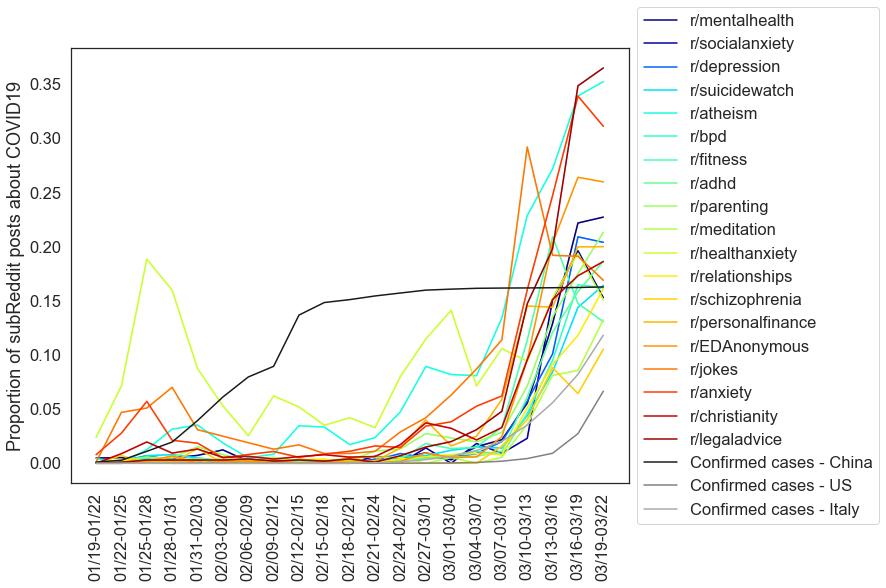

In [262]:
# subredditsx = ['anxiety', 'healthanxiety']
plot_across_time(subreddits,y_col = 'covid_boolean', y_col_div_by = 'total_posts',
                  ylabel='Proportion of subReddit posts about COVID19',filter_small = True, small_value = 150, 
                  plot_raw = True,  plot_line = False, alpha = 0.3, plot_covid_curves = True, zscore = False)



In [263]:
### Hypochondriac symptoms predict overall concern 1.5 months before. 
### All of Reddit converges on the same topic

In [264]:
'''
# Early:
01/19: {'created_utc': 1579618862, 'num_comments': 7, 'title': 'The breaking news stories about the coronavirus is making me really nervous and I’m not sure what to do?', 'selftext': 'I’ve been seeing a lot of news stories today about an incurable, lethal disease originating in China spreading to other countries. I know the media often over exaggerates things like this, but WHO is debating whether or not to declare this an international emergency. Nothing triggers my anxiety worse than things like this, if anyone has any advice on how to cope/can inform me on it I would really appreciate it!', 'score': 1},
01/19: {'created_utc': 1579543321, 'num_comments': 1, 'title': 'Wuhan Virus anxiety', 'selftext': "Right off the bat, i'm not chinese or live anywhere in the eastern part of the globe. But i am a massive hypochondriac and terrified of a global outbreak.  \n\n\nThis morning, i saw an article showing a video of airline passengers being screened by medical personal in hazmat suits. With the article spewing the whole sensationalized clickbait crap about an apocalyptic global epidemic.  \n\n\nAnd after seeing it i quickly spiraled into stress and anxiety. Even though i was able to avoid a full on panic attack, this article bothered me to the point that ll i've been thinking about is an outbreak for the rest of the day just by reading a news article for a few minutes.  \n\n\nI hope everybody in the east can stay safe and healthy, the worst i've had today is nearly having a panic attack. Can't imagine how worrying it is over there.", 'score': 1},
01/25: {'created_utc': 1580175419, 'num_comments': 3, 'title': 'so so so scared', 'selftext': 'this corona virus has me absolutely terrified. i know there\'s all these "low mortality" things, but i read to far into the conspiracies and the videos of chinese hospitals and doctors crying for help. \n\nive washed and sanitized my hands to the point they\'re cracked and bleeding. i won\'t leave the house anymore unless its 100% necessary.and even when i do i don\'t touch ANYTHING\n\nim so scared, breaking down crying, i can\'t even eat anymore. nothing the news or cdc says can calm me down because i am fully convinced china is lying and that this could even be a bioweapon. i heard it\'s mutated already and 300,000-1,000,000 people fled china possibly infected. i feel doomed'}



# Suicidality
03/16:        {'created_utc': 1584584727, 'num_comments': 0, 'title': 'I feel like a scared child but I have no parents to run to for safety', 'selftext': "I'm far from being actually alone, I don't even live alone, yet right now with the virus, the economic status, and the high stress everyone is feeling is making me feel like my bones are trying to crawl out of my flesh. I want it to stop, I want to scream and cry, I want to hide and honestly just fucking die so I don't have to live with any of these feelings anymore. I work minimum wage, I'm saving for the house I'm renting in May, but if I lose my job or can't work because of Covid-19 I am absolutely fucked. I am terrified and I feel pinned down by this overwhelming feeling it's all going to get so so much worse...Part of me wishes the world would just end. No worried then. No stress. I'm dreading my state saying we must stay home because my father is bipolar and refuses to go to therapy or get medication so I don't feel safe outside of my room and most of my social interactions outside of work come in arguments with him because he can never be wrong. He has to be right. I wish it would all just freeze or disappear.", 'score': 1},
# Works at hospital
03/16:        {'created_utc': 1584581971, 'num_comments': 0, 'title': 'Feeling overwhelmed about corona and working at the hospital', 'selftext': "I live in New York and work in a hospital. We were short on supplies even before the virus really became a thing here. We don't have masks to give patients. We are not allowed to wear masks ourself. We have been mandated to work and even been told to continue coming to work even if we have had contact with a confirmed positive. We just have to take our temperature daily &amp; we are only to wear a mask if we have active respiratory symptoms.\n\nI have constant shortness of breath and chest pains and pressure due to anxiety which has me constantly stressed. My throat is super dry and idk why. Dry throat and stress leaves you more susceptible to infection in addition to working in a war zone with no protection daily.\n\nI feel so anxious and overwhelmed. I was finally getting my panic attacks sorta under control by going out mor and starting therapy. That's all on hold for the indefinite future. Im constantly afraid of having another panic attack or being in the position where I feel like I'm actually dying and unable to see a provider due to the system being overwhelmed.\n\nThe only positive thing I have going on right now is that its about to be spring and I can garden while social distancing.", 'score': 1},
# Buying guns
03/16:        {'created_utc': 1584581413, 'num_comments': 24, 'title': 'Are we going to all die and go into an apocalypse? The media is starting to freak me out because of the Corona Virus', 'selftext': "I keep on seeing the Corona Virus everywhere now I hear people are buying guns then people are talking about Germany and how bad it is there. I thought that America was handling it very well. And we are on top of it? I'm freaking out. Am I overthinking between all the youtube posts I'm buggin.", 'score': 0},

03/16:        {'created_utc': 1584574890, 'num_comments': 1, 'title': 'My mom is driving herself crazy because of the COVID-19', 'selftext': 'My mom never have suffer from anxiety or other mental illness like OCD, etc. \nSince the COVID-19, we steam and sanitize our house all the day with the steamer machine, we use other product like Clorox or Javex, if she touches something in the house she wash her hand, I suffer from anxiety and it doesn’t help at all! I feel stress will kill our brain before the COVID-19, I’m tired, really tired, I want just this stupid virus to end and to go out. All we do is talking about this virus, the media is not helping at all... my head is gonna explode.', 'score': 3},
# GAD + Isolation  
      {'created_utc': 1584570369, 'num_comments': 0, 'title': 'Being single and living alone is absolutely brutal right now.', 'selftext': 'I live with generalized anxiety disorder and already have major anxiety regarding my health. Had the flu end of January pretty bad and then hives post flu- I’m miserable and was finally getting back on track and then this.\n\n\nI am terrified. Just being alone all day. And can’t see my parents or friends. Or brother. I have been so anxious through all of this for many reasons. \n\nfinally got the work from home okay on Monday but now being told by higher ups where I work (a health science college at a major uni) that someone needs to be in my office during the day, though it’s not essential. I hate the idea of going to my office which is connected to the main hospital in my city.\n\nAnyway. I really could use some people to talk to as I don’t have that many friends and that’s what I need now. I need some more connections and chances to get to other people and distract from the virus.\n\nThanks', 'score': 0},

'''

'\n# Early:\n01/19: {\'created_utc\': 1579618862, \'num_comments\': 7, \'title\': \'The breaking news stories about the coronavirus is making me really nervous and I’m not sure what to do?\', \'selftext\': \'I’ve been seeing a lot of news stories today about an incurable, lethal disease originating in China spreading to other countries. I know the media often over exaggerates things like this, but WHO is debating whether or not to declare this an international emergency. Nothing triggers my anxiety worse than things like this, if anyone has any advice on how to cope/can inform me on it I would really appreciate it!\', \'score\': 1},\n01/19: {\'created_utc\': 1579543321, \'num_comments\': 1, \'title\': \'Wuhan Virus anxiety\', \'selftext\': "Right off the bat, i\'m not chinese or live anywhere in the eastern part of the globe. But i am a massive hypochondriac and terrified of a global outbreak.  \n\n\nThis morning, i saw an article showing a video of airline passengers being screened by

In [265]:
subreddits2 = ['relationships','mindfulness', 'healthanxiety', 'anxiety', 'suicidewatch', 'depression', 'ptsd', 'adhd', 
              'bpd', 'paranoia', 'socialanxiety', 'schizophrenia', 'bipolarreddit', 'alcoholism', 'addiction',]







### Social anxiety: less posts, more words on average per post

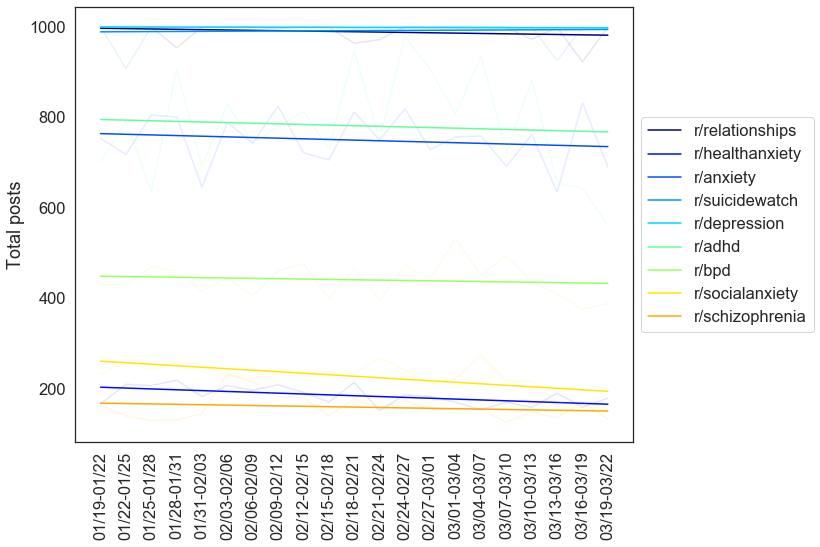

In [266]:
plot_across_time(subreddits2, y_col = 'total_posts', y_col_div_by = False, zscore = False, 
                 ylabel='Total posts',
                 small_value = 150, plot_raw = True, 
                     plot_line = True, alpha = 0.1, plot_covid_curves = False)

In [0]:
plot_across_time(subreddits2, y_col = 'total_posts', y_col_div_by = False, zscore = True, 
                 ylabel='Total posts',
                 small_value = 150, plot_raw = True, 
                     plot_line = True, alpha = 0.1, plot_covid_curves = False)


In [0]:
plot_across_time(subreddits2, y_col = 'all_words', y_col_div_by = 'total_posts', 
                 ylabel='Average words per post',
                 small_value = 150, plot_raw = True, zscore = True,
                     plot_line = True, alpha = 0.3, plot_covid_curves = False)

# Sentiment analysis: social anxiety getting less negative!

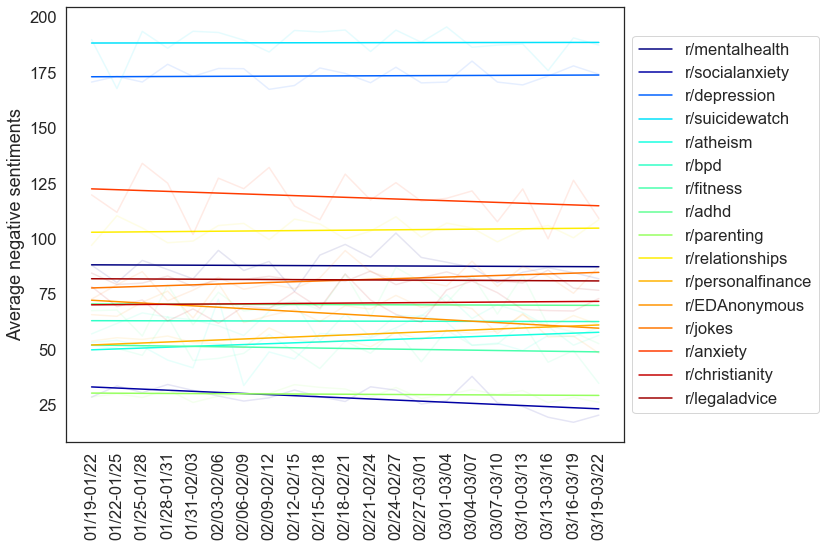

In [268]:
plot_across_time(subreddits, y_col = 'sent_neg', y_col_div_by = False, 
                 ylabel='Average negative sentiments',zscore = False,
                 filter_small = True, small_value = 200, plot_raw = True, 
                     plot_line = True, alpha = 0.1, plot_covid_curves = False)


In [0]:

# input y variable across time



In [0]:
subreddit = 'socialanxiety'
y_col = 'sent_neg'
df_subreddit = pd.read_csv(output_dir+'features_{}_0.csv'.format(subreddit))

# Load data
xs = list(set(df_subreddit.date.values))
try: xs.remove(np.nan)
except: pass
xs.sort()
ys = []
cs = []
for day in xs:
    df_subreddit_day = df_subreddit[df_subreddit.date == day]
    y = df_subreddit_day[y_col].values
    ys.append(y)
    median_value = int(np.median(y))
    median_max = np.percentile(y,90)
    color = median_max*10**2
    color = np.max(y)*10**2
    cs.append('hsl({}%,50%,50%)'.format(color))


# plot
fig = go.Figure(data=[go.Box(
    y=ys[i],
    marker_color=cs[i],
    name = xs[i],
    ) for i in range(len(xs))])

# format the layout
fig.layout.update(
    xaxis=dict(showgrid=False, zeroline=False, showticklabels=True,   ticktext = xs),
    yaxis=dict(zeroline=False, gridcolor='white'),
    paper_bgcolor='rgb(233,233,233)',
    plot_bgcolor='rgb(233,233,233)',
    showlegend=False,
    title=y_col+' as COVID-19 grows'
)

fig.show()

In [0]:
subreddit = 'socialanxiety'
df_subreddit = pd.read_csv(output_dir+'features_{}_0.csv'.format(subreddit))
fig = px.scatter(df_subreddit, x="date", y="sent_neg", color="suicide_bool",hover_name='posts',
                 title=subreddit)

fig.show()

### Suicidality

In [0]:
subreddit = 'suicidewatch'
df_subreddit = pd.read_csv(output_dir+'features_{}_0.csv'.format(subreddit))
fig = px.scatter(df_subreddit, x="date", y="sent_neg", color="sent_neg",hover_name='posts',
                 title="Numeric 'size' values mean continous color")

fig.show()

In [0]:
subreddit = 'suicidewatch'
df_subreddit = pd.read_csv(output_dir+'features_{}_0.csv'.format(subreddit))
fig = px.scatter(df_subreddit, x="date", y="sent_neg", color="covid_boolean",hover_name='posts',
                 title=subreddit+' with COVID-19 related posts in yellow')

fig.show()

In [0]:
subreddit = 'socialanxiety'
df_subreddit = pd.read_csv(output_dir+'features_{}_0.csv'.format(subreddit))
fig = px.scatter(df_subreddit, x="date", y="sent_neg", color="suicide_bool",hover_name='posts',
                 title=subreddit+' with suicidal related posts in yellow')

fig.show()




In [0]:
# The fact that it may be affecting ED more or certain disorders more could be useful
# How personal finance may be connected to mental could be studied: If personal finance become more similar to some disorder (tfidf))
# Target at risk people who post regularly and stopped posting? 



# TFIDF

In [0]:
# reload(extract_features)

In [0]:
# Create a corpus to build the matrix
posts_all = []
for sr in subreddits2:
    df_subreddit = pd.read_csv(output_dir+'features_{}_0.csv'.format(sr))
    posts = df_subreddit.posts.values
    posts_all.append(posts)
    

corpus = [n for i in posts_all for n in i]
# remove nan
corpus = [n for n in corpus if isinstance(n,str)]

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(lowercase=True, ngram_range=(1,3), stop_words='english',
                        max_features=512, min_df=2, max_df=0.8)



# Build matrix
vectorizer.fit_transform(corpus)

In [0]:
# Comment so it won't run



In [0]:
feature_array = np.array(vectorizer.get_feature_names())
n = 15

split = 0.9



for sr in subreddits2:
    df_subreddit = pd.read_csv(output_dir+'features_{}_0.csv'.format(sr))
    posts = df_subreddit.posts.values
    posts = [n for n in posts if isinstance(n,str)]
    split_i = int(len(posts)*split)
    posts_before = posts[:split_i]
    posts_after = posts[split_i:]
    posts2 = [posts_before, posts_after]
    posts_names = ['before', 'after']
    for i in range(2):
        response = vectorizer.transform(posts2[i])
        tfidf_sorting = np.argsort(response.toarray()).flatten()[::-1]
        top_n = feature_array[tfidf_sorting][:n]
        print('\n====={}==={}'.format(sr, posts_names[i]))
        print(top_n)
    print('\n\n===============')

In [0]:
# # Alternative method
# def tfidf(X_train_sentences = posts, lower_case = True, ngram_range = (1,3), max_features=512, min_df=2, max_df=0.8, model = 'svm'):
#     sw = stopwords.words('english')
#     vectorizer = TfidfVectorizer(lowercase=lower_case, ngram_range=ngram_range, stop_words=sw,max_features=max_features, min_df=min_df, max_df=max_df)
#     train_vectors = vectorizer.fit_transform(X_train_sentences).toarray()
#     feature_names = vectorizer.get_feature_names()
#     feature_names = ['tfidf_'+n for n in feature_names]
#     return train_vectors, feature_names
    
# X_test_sentences = False
# vectors, feature_names = tfidf(X_train_sentences = posts_all_days, lower_case = True, ngram_range = (1,3), max_features=512, min_df=2, max_df=0.8, model = 'svm')
    